**Background:**

As a talent sourcing and management company, we are interested in finding talented individuals for sourcing these candidates to technology companies. Finding talented candidates is not easy, for several reasons. The first reason is one needs to understand what the role is very well to fill in that spot, this requires understanding the client’s needs and what they are looking for in a potential candidate. The second reason is one needs to understand what makes a candidate shine for the role we are in search for. Third, where to find talented individuals is another challenge.

The nature of our job requires a lot of human labor and is full of manual operations. Towards automating this process we want to build a better approach that could save us time and finally help us spot potential candidates that could fit the roles we are in search for. Moreover, going beyond that for a specific role we want to fill in we are interested in developing a machine learning powered pipeline that could spot talented individuals, and rank them based on their fitness.

We are right now semi-automatically sourcing a few candidates, therefore the sourcing part is not a concern at this time but we expect to first determine best matching candidates based on how fit these candidates are for a given role. We generally make these searches based on some keywords such as “full-stack software engineer”, “engineering manager” or “aspiring human resources” based on the role we are trying to fill in. These keywords might change, and you can expect that specific keywords will be provided to you.

Assuming that we were able to list and rank fitting candidates, we then employ a review procedure, as each candidate needs to be reviewed and then determined how good a fit they are through manual inspection. This procedure is done manually and at the end of this manual review, we might choose not the first fitting candidate in the list but maybe the 7th candidate in the list. If that happens, we are interested in being able to re-rank the previous list based on this information. This supervisory signal is going to be supplied by starring the 7th candidate in the list. Starring one candidate actually sets this candidate as an ideal candidate for the given role. Then, we expect the list to be re-ranked each time a candidate is starred.


**Data Description:**

The data comes from our sourcing efforts. We removed any field that could directly reveal personal details and gave a unique identifier for each candidate.

Attributes:
* id : unique identifier for candidate (numeric)
* job_title : job title for candidate (text)
* location : geographical location for candidate (text)
* connections: number of connections candidate has, 500+ means over 500 (text)

Output (desired target):
* fit - how fit the candidate is for the role? (numeric, probability between 0-1)
* Keywords: “Aspiring human resources” or “seeking human resources”

**Goal(s):**

* Predict how fit the candidate is based on their available information (variable fit)

**Success Metric(s):**

* Rank candidates based on a fitness score.
* Re-rank candidates when a candidate is starred.

**Bonus(es):**

* We are interested in a robust algorithm, tell us how your solution works and show us how your ranking gets better with each starring action.
* How can we filter out candidates which in the first place should not be in this list?
* Can we determine a cut-off point that would work for other roles without losing high potential candidates?
* Do you have any ideas that we should explore so that we can even automate this procedure to prevent human bias?

**Data Loading and Exploration**

In [25]:
import os
import random
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt


import nltk
import torch
import gensim.downloader as api
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.test.utils import get_tmpfile
from scipy.spatial.distance import cosine
from gensim.models import KeyedVectors, Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

# random
import random
# pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# Ignore warnings
warnings.filterwarnings('ignore')

In [26]:
df = pd.read_csv('potential_talents.csv')

In [27]:
df.head()

,id,job_title,location,connection,fit
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85,NaN
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+,NaN
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44,NaN
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+,NaN
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+,NaN


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          104 non-null    int64  
 1   job_title   104 non-null    object 
 2   location    104 non-null    object 
 3   connection  104 non-null    object 
 4   fit         0 non-null      float64
dtypes: float64(1), int64(1), object(3)
memory usage: 4.2+ KB


* We have 104 entries without missing values
* the fit column is completely null, it's our target column and we are going to fill it with the cosine similirity 

In [29]:
df.drop('fit', axis=1, inplace=True)

In [30]:
print('The number of duplicated rows is:', df.duplicated().sum())

The number of duplicated rows is: 0


The result may be affected by the id column, we can try to delete the id column and search for duplicated value again

In [31]:
df_dup = df.drop(['id'], axis = 1)                    
print("Number of duplicate entries:", df_dup.duplicated().sum()) 

Number of duplicate entries: 51


There are 51 duplicated rows, and I think this is due to an inaccurate web scraping program or something similar. But let drop them.

In [32]:
# See duplicate entries
df[df_dup.duplicated(keep=False)]  

,id,job_title,location,connection
0,1,2019 C.T. Bauer College of Business Graduate (Magna Cum Laude) and aspiring Human Resources professional,"Houston, Texas",85
1,2,Native English Teacher at EPIK (English Program in Korea),Kanada,500+
2,3,Aspiring Human Resources Professional,"Raleigh-Durham, North Carolina Area",44
3,4,People Development Coordinator at Ryan,"Denton, Texas",500+
4,5,Advisory Board Member at Celal Bayar University,"İzmir, Türkiye",500+
...,...,...,...,...
60,61,HR Senior Specialist,San Francisco Bay Area,500+
61,62,Seeking Human Resources HRIS and Generalist Positions,Greater Philadelphia Area,500+
62,63,Student at Chapman University,"Lake Forest, California",2
63,64,"SVP, CHRO, Marketing & Communications, CSR Officer | ENGIE | Houston | The Woodlands | Energy | GPHR | SPHR","Houston, Texas Area",500+


In [33]:
# drop duplicated rows and rebuild the dataframe
df_dup = df_dup.drop_duplicates()                                    
df = pd.concat([df['id'], df_dup], axis = 1).dropna(axis = 0)   
print("Shape of non-duplicated dataframe:", df.shape)  

Shape of non-duplicated dataframe: (53, 4)


We have now 53 entries without any duplicates values

In [34]:
df = df.reset_index(drop = True)

In [35]:
# it's interesting also to check the most frequent words
words_counts = Counter()
for i in range(len(df)):
    for word in df.job_title[i].split(" "):
        words_counts[word] += 1

print('Number of total words', len(words_counts))
words_counts.most_common()

Number of total words 221


[('Human', 34),
 ('Resources', 29),
 ('at', 22),
 ('and', 13),
 ('Aspiring', 11),
 ('|', 10),
 ('Professional', 7),
 ('in', 6),
 ('University', 6),
 ('Seeking', 6),
 ('Business', 5),
 ('Student', 5),
 ('Generalist', 5),
 ('Manager', 5),
 ('of', 4),
 ('Specialist', 4),
 ('&', 4),
 ('Management', 4),
 ('seeking', 4),
 ('', 4),
 ('an', 3),
 ('Director', 3),
 ('for', 3),
 ('College', 2),
 ('aspiring', 2),
 ('professional', 2),
 ('Coordinator', 2),
 ('HR', 2),
 ('Senior', 2),
 ('internship', 2),
 ('Resources,', 2),
 ('Staffing', 2),
 ('North', 2),
 ('a', 2),
 ('Resources.', 2),
 ('Major', 2),
 ('to', 2),
 ('Information', 2),
 ('Systems', 2),
 ('-', 2),
 ('Position', 2),
 ('2019', 1),
 ('C.T.', 1),
 ('Bauer', 1),
 ('Graduate', 1),
 ('(Magna', 1),
 ('Cum', 1),
 ('Laude)', 1),
 ('Native', 1),
 ('English', 1),
 ('Teacher', 1),
 ('EPIK', 1),
 ('(English', 1),
 ('Program', 1),
 ('Korea)', 1),
 ('People', 1),
 ('Development', 1),
 ('Ryan', 1),
 ('Advisory', 1),
 ('Board', 1),
 ('Member', 1),
 ('Ce

The top 6 words are Human, Resources, at, and, Aspiring and Professional. Words like (and) and (at) have no individual meaning,they belong to stopwords, and we are going to remove them in the cleaning part.

**Data Cleaning**

* Remove special characters and punctuation.
* Abbreviations replacement with their description.
* Because the Keywords are: Aspiring human resources or seeking human resources, we will replace all of the HR to human resources.
* We will transform all the text to lower case
* Remove stopwords and apply lemmatization

In [36]:
# removing special characters and punctions
df = df.replace({'job_title' : { "[\'!#)$%&(*+-./:;<=>?@[\]^_`{|}~\n]" : " "}}, regex=True)
df = df.replace({'connection' : { "[\'!#)$%&(*+-./:;<=>?@[\]^_`{|}~\n]" : " "}}, regex=True)
df = df.replace({'location' : { "[\'!#)$%&(*+-./:;<=>?@[\]^_`{|}~\n]" : " "}}, regex=True)

# Text normalization - Replace 'HR' by 'Human Resources' to make our model smarter
df['job_title'] = df['job_title'].str.replace("HR", " Human Resources ")  

In [37]:
# transform text to lower case
df['job_title'] = df['job_title'].str.lower()
df['location'] = df['location'].str.lower()
df.head(4)

,id,job_title,location,connection
0,1,2019 c t bauer college of business graduate magna cum laude and aspiring human resources professional,houston texas,85
1,2,native english teacher at epik english program in korea,kanada,500
2,3,aspiring human resources professional,raleigh durham north carolina area,44
3,4,people development coordinator at ryan,denton texas,500


In [38]:
# function that remove stopwords and apply lemmatization
def cleaning(df, col):
    
    stop_words = set(stopwords.words('english'))
    for i in range (len(df)):
        word_tokens = word_tokenize(df[col][i])
        tokens_without_sw = [w for w in word_tokens if w not in stop_words]
        lemmatized_sentence = []
        for word in tokens_without_sw:
            lemmatized_sentence.append(WordNetLemmatizer().lemmatize(word))
        df[col][i] = TreebankWordDetokenizer().detokenize(lemmatized_sentence) 


In [39]:
cleaning(df, 'job_title')
df.head(3)

,id,job_title,location,connection
0,1,2019 c bauer college business graduate magna cum laude aspiring human resource professional,houston texas,85
1,2,native english teacher epik english program korea,kanada,500
2,3,aspiring human resource professional,raleigh durham north carolina area,44


**Modeling**

We will use 4 word embeddings techniques and one doc embeddings technique to find the similarities between the targeted sentences and each job title.

1. Word Embedding:

       a. TF-IDF  : a statistical measure used to determine the mathematical significance of words in documents.

       b. Glove   : In GloVe, we measure the similarity of the hidden factors between words to predict their co-occurrence count.

       c. Word2Vec : Google News model that takes texts as training data for a neural network. The resulting embedding captures whether words appear in similar contexts

       d. Bert : It's a Transformer based model, an attention mechanism that learns contextual relations between words (or sub-words) in a text.


2. Doc Embedding : 

       a. Doc2Vec : Doc2vec is an NLP tool for representing documents as a vector and is a generalizing of the word2vec method

**1.a TF-IDF**

In [40]:
# Convert job_title column into a list
job_title_list = list(df['job_title'])                    

# Vectorize job_title_list
vectorizer = TfidfVectorizer().fit(job_title_list)                    
X = vectorizer.transform(job_title_list)   

# Get feature names in all the documents
feature_names = vectorizer.get_feature_names()                  
print("Number of unique features: ", len(feature_names)) 
print("First 5 features: ", feature_names[:10]) 

# Convert job titles into arrays
tfidf_vector = X.toarray()                                  
print("Shape of Tfidf vector: ", tfidf_vector.shape)  

Number of unique features:  180
First 5 features:  ['2019', '2020', '2621', '408', '709', 'administration', 'administrative', 'admission', 'advisory', 'always']
Shape of Tfidf vector:  (53, 180)


We converted all the unique words to columns and fill the rows by computing the TF-IDF value. And now, we can calculate the relation between the targeted sentence and each job title.

In [41]:
# function to compute cosine similarity
def similarity(phrase, column_name):
    # Convert search phrase into a vector
    X = vectorizer.transform(phrase)                    
    X_vector = X.toarray()
    
    # Calcualte Tfidf cosine similarity and add it to pt dataframe
    sim_score_list = []
    for x in range (len(df)):
        sim_score_list.append(1 - cosine(tfidf_vector[x], X_vector))

    df[column_name] = sim_score_list

In [42]:
# Before computing the similarity between the target sentence and the job title , we need to clean the target sentence first
phrases = pd.DataFrame({'phrase' : ['Aspiring human resources']})
cleaning(phrases, 'phrase')

In [43]:
similarity([phrases.phrase[0]], 'fit_TF-IDF')

We can now see the top rows job title that match the most to 'Aspiring human ressources' using TF-IDF technique

In [44]:
df.sort_values(by ='fit_TF-IDF', ascending = False).head(10)

,id,job_title,location,connection,fit_TF-IDF
2,3,aspiring human resource professional,raleigh durham north carolina area,44,0.765002
45,97,aspiring human resource professional,kokomo indiana area,71,0.765002
5,6,aspiring human resource specialist,greater new york city area,1,0.673329
21,73,aspiring human resource manager seeking internship human resource,houston texas area,7,0.606927
12,27,aspiring human resource management student seeking internship,houston texas area,500,0.431808
20,72,business management major aspiring human resource manager,monroe louisiana area,5,0.429455
14,66,experienced retail manager aspiring human resource professional,austin texas area,57,0.403297
22,74,human resource professional,greater boston area,16,0.393063
6,7,student humber college aspiring human resource generalist,kanada,61,0.389175
8,10,seeking human resource human resource generalist position,greater philadelphia area,500,0.386319


In [45]:
df.sort_values(by ='fit_TF-IDF', ascending = False).tail(5)

,id,job_title,location,connection,fit_TF-IDF
35,87,bachelor science biology victoria university wellington,baltimore maryland,40,0.0
34,86,information system specialist programmer love data organization,gaithersburg maryland,4,0.0
33,85,rrp brand portfolio executive jti japan tobacco international,greater philadelphia area,500,0.0
28,80,junior me engineer information system,myrtle beach south carolina area,52,0.0
52,104,director administration excellence logging,katy texas,500,0.0


As we can observe the top rows have the same phrase in their job title and all the lowest ones have no relation with the targeted phrase at all.

**1.b Glove**

In [46]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove*.zip

In [47]:
from gensim.test.utils import get_tmpfile

# Create temp file and save converted embedding into it
target_file = get_tmpfile('word2vec.6B.50d.txt')
glove2word2vec('glove.6B.50d.txt', target_file) 

# Load the converted embedding into memory
glove_model = KeyedVectors.load_word2vec_format(target_file)

# Save as binary data
glove_model.save_word2vec_format('word2vec.6B.50d.bin.gz', binary=True)

In [48]:
# Define a function to vectorize a sentence's words
def doc_token_vectors(sentence, model, sentence_vector_list, vector_dimensions):
    word_tokens = word_tokenize(sentence)
    filtered_words = [w for w in word_tokens if w in model.key_to_index.keys()]
    
    for j in range(0, len(word_tokens)):
        if word_tokens[j] in filtered_words:
            token_vector = model[word_tokens[j]]
        else:
            token_vector = np.zeros(vector_dimensions)
        sentence_vector_list.append(token_vector)
    
    return sentence_vector_list

In [49]:
def glove_fit_score(df, col, model, vector_dimensions, phrase, fitt_col_name):
    # Vectorize job title using the model
    model_vectors = []
    for i in range(len(df)):
        model_sentence_vector = []
        doc_token_vectors(df[col][i], model, model_sentence_vector, vector_dimensions)
        model_vectors.append(model_sentence_vector)

    # Vectorize searched phrase using the model
    model_search_phrase_vector = []
    doc_token_vectors(phrase, model, model_search_phrase_vector, vector_dimensions)

    # Calculate cosine similarity between searched phrase and job title
    model_similarity =[]
    for i in range(len(df)):
        sim_score = 1 - cosine(np.mean(model_vectors[i], axis = 0), np.mean(model_search_phrase_vector, axis =0))
        model_similarity.append(sim_score)

    # Add model similarity score to the pt dataframe
    df[fitt_col_name] = model_similarity

In [50]:
glove_fit_score(df, 'job_title', glove_model, 50, phrases.phrase[0], 'fit_Glove')

In [51]:
df.sort_values(by =['fit_Glove'], ascending = False).head(10)

,id,job_title,location,connection,fit_TF-IDF,fit_Glove
8,10,seeking human resource human resource generalist position,greater philadelphia area,500,0.386319,0.960262
49,101,human resource generalist loparex,raleigh durham north carolina area,500,0.224720,0.934310
22,74,human resource professional,greater boston area,16,0.393063,0.927079
19,71,human resource generalist scottmadden inc,raleigh durham north carolina area,500,0.179597,0.914006
36,88,human resource management major,milpitas california,18,0.246336,0.912234
13,28,seeking human resource opportunity,chicago illinois,390,0.263981,0.906700
21,73,aspiring human resource manager seeking internship human resource,houston texas area,7,0.606927,0.903436
37,89,director human resource ey,greater atlanta area,349,0.215787,0.902769
47,99,seeking human resource position,las vegas nevada area,48,0.273133,0.900974
5,6,aspiring human resource specialist,greater new york city area,1,0.673329,0.900954


In [52]:
df.sort_values(by ='fit_Glove', ascending = False).tail()

,id,job_title,location,connection,fit_TF-IDF,fit_Glove
46,98,student,houston texas area,4,0.0,0.487681
35,87,bachelor science biology victoria university wellington,baltimore maryland,40,0.0,0.485134
4,5,advisory board member celal bayar university,i̇zmir türkiye,500,0.0,0.484422
43,95,student westfield state university,bridgewater massachusetts,57,0.0,0.484065
9,11,student chapman university,lake forest california,2,0.0,0.432108


As in the TF-IDF, the top rows have the same phrase in their job title. The big difference between the TF-IDF and GloVe model result is the last rows score. In the TF-IDF, it's scoring the unrelated titles with 0 but the GloVe model gives them a high score, which is around 50% of matching!!

**1.C Word2Vec**

It is a popular word embedding technique using a 2-layer neural network.It works in a way such that a well-trained set of word vectors will place similar words close to each other in that space.

There are two main training algorithims within Word2Vec: Continuous Bag of Words(CBOW) and Skip-Gram. The major difference between these two methods is that CBOW is using context to predict a target word while skip-gram is using a word to predict a target context. Generally, the skip-gram method can have a better performance compared with CBOW method, for it can capture two semantics for a single word.

In [53]:
GoogleNews_model = api.load('word2vec-google-news-300')

In [54]:
def w2v_fit_score(df, col, model, vector_dimensions, phrase, fitt_col_name):
    # Vectorize job title using the model
    model_vectors = []
    for i in range(len(df)):
        model_sentence_vector = []
        doc_token_vectors(df[col][i], model, model_sentence_vector, vector_dimensions)
        model_vectors.append(model_sentence_vector)

    # Vectorize searched phrase using the model
    model_search_phrase_vector = []
    doc_token_vectors(phrase, model, model_search_phrase_vector, vector_dimensions)

    # Calculate cosine similarity between searched phrase and job title
    model_similarity =[]
    for i in range(len(df)):
        sim_score = 1 - cosine(np.mean(model_vectors[i], axis = 0), np.mean(model_search_phrase_vector, axis =0))
        model_similarity.append(sim_score)

    # Add model similarity score to the pt dataframe
    df[fitt_col_name] = model_similarity

In [55]:
w2v_fit_score(df, 'job_title', GoogleNews_model, 300, phrases.phrase[0], 'fit_wave2vec')

In [56]:
df.sort_values(by ='fit_wave2vec', ascending = False).head(10)

,id,job_title,location,connection,fit_TF-IDF,fit_Glove,fit_wave2vec
2,3,aspiring human resource professional,raleigh durham north carolina area,44,0.765002,0.847285,0.842219
45,97,aspiring human resource professional,kokomo indiana area,71,0.765002,0.847285,0.842219
5,6,aspiring human resource specialist,greater new york city area,1,0.673329,0.900954,0.825216
22,74,human resource professional,greater boston area,16,0.393063,0.927079,0.789636
21,73,aspiring human resource manager seeking internship human resource,houston texas area,7,0.606927,0.903436,0.769422
8,10,seeking human resource human resource generalist position,greater philadelphia area,500,0.386319,0.960262,0.748053
6,7,student humber college aspiring human resource generalist,kanada,61,0.389175,0.735721,0.741194
26,78,human resource generalist schwan,amerika birleşik devletleri,500,0.224720,0.830349,0.728771
49,101,human resource generalist loparex,raleigh durham north carolina area,500,0.224720,0.934310,0.728771
13,28,seeking human resource opportunity,chicago illinois,390,0.263981,0.906700,0.691059


In [57]:
df.sort_values(by ='fit_wave2vec', ascending = False).tail(10)

,id,job_title,location,connection,fit_TF-IDF,fit_Glove,fit_wave2vec
38,90,undergraduate research assistant styczynski lab,greater atlanta area,155,0.0,0.580903,0.227543
39,91,lead official western illinois university,greater chicago area,39,0.0,0.544827,0.212952
46,98,student,houston texas area,4,0.0,0.487681,0.210494
43,95,student westfield state university,bridgewater massachusetts,57,0.0,0.484065,0.208190
9,11,student chapman university,lake forest california,2,0.0,0.432108,0.206166
41,93,admission representative community medical center long beach,long beach california,9,0.0,0.655437,0.204791
33,85,rrp brand portfolio executive jti japan tobacco international,greater philadelphia area,500,0.0,0.499837,0.198299
52,104,director administration excellence logging,katy texas,500,0.0,0.757059,0.190146
51,103,always set success,greater los angeles area,500,0.0,0.595869,0.169893
4,5,advisory board member celal bayar university,i̇zmir türkiye,500,0.0,0.484422,0.120219


The top scores for the Glove model are better than the Word2Vec model but the last 10 scores for wave2vec are lower which is good.

**1.D BERT (Bidirectional Encoded Representations from Transformers)**

BERT is a modern NLP technique developed by Google in 2018. It is used to solve a varierty of NLP problems including similarity of sentences. We'll use this technique to get similarity scores for our job title.

In [58]:
# pip install sentence_transformers

In [59]:
from sentence_transformers import SentenceTransformer
# Build BERT_base model
bert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [60]:
# Convert job titles into BERT embedded vectors
bert_job_title_embeddings = bert_model.encode(list(df.job_title))
bert_job_title_embeddings.shape

(53, 768)

In [61]:
# Convert search phrase into a BERT embedded vector
bert_search_phrase_embedding = bert_model.encode(phrases.phrase[0])
bert_search_phrase_embedding.shape

(768,)

In [63]:
# Calculate cosine similarity between job title and search phrase vectors
bert_cosine_similarity = []
for i in range(len(df)):
    cos_sim = 1 - cosine(bert_job_title_embeddings[i], bert_search_phrase_embedding)
    bert_cosine_similarity.append(cos_sim)
    
# Add BERT_cosine_similarity column in the pt dataframe
df['fit_BERT'] = bert_cosine_similarity

In [64]:
df.sort_values(by ='fit_BERT', ascending = False).head(10)

,id,job_title,location,connection,fit_TF-IDF,fit_Glove,fit_wave2vec,fit_BERT
5,6,aspiring human resource specialist,greater new york city area,1,0.673329,0.900954,0.825216,0.955137
2,3,aspiring human resource professional,raleigh durham north carolina area,44,0.765002,0.847285,0.842219,0.948828
45,97,aspiring human resource professional,kokomo indiana area,71,0.765002,0.847285,0.842219,0.948828
30,82,aspiring human resource professional energetic team focused leader,austin texas area,174,0.330575,0.755774,0.621360,0.885530
47,99,seeking human resource position,las vegas nevada area,48,0.273133,0.900974,0.654475,0.849293
13,28,seeking human resource opportunity,chicago illinois,390,0.263981,0.906700,0.691059,0.841447
22,74,human resource professional,greater boston area,16,0.393063,0.927079,0.789636,0.809261
8,10,seeking human resource human resource generalist position,greater philadelphia area,500,0.386319,0.960262,0.748053,0.775801
24,76,aspiring human resource professional passionate helping create inclusive engaging work environment,new york new york,212,0.255275,0.827730,0.612162,0.754890
21,73,aspiring human resource manager seeking internship human resource,houston texas area,7,0.606927,0.903436,0.769422,0.752413


In [65]:
df.sort_values(by ='fit_BERT', ascending = False).tail(10)

,id,job_title,location,connection,fit_TF-IDF,fit_Glove,fit_wave2vec,fit_BERT
38,90,undergraduate research assistant styczynski lab,greater atlanta area,155,0.000000,0.580903,0.227543,0.442219
9,11,student chapman university,lake forest california,2,0.000000,0.432108,0.206166,0.426179
31,83,human resource manager endemol shine north america,los angeles california,268,0.143876,0.760542,0.531437,0.419740
11,13,human resource coordinator intercontinental buckhead atlanta,atlanta georgia,500,0.148766,0.695674,0.521165,0.387097
1,2,native english teacher epik english program korea,kanada,500,0.000000,0.521773,0.240536,0.384784
39,91,lead official western illinois university,greater chicago area,39,0.000000,0.544827,0.212952,0.357181
33,85,rrp brand portfolio executive jti japan tobacco international,greater philadelphia area,500,0.000000,0.499837,0.198299,0.253621
44,96,student indiana university kokomo business management retail manager delphi hardware paint,lafayette indiana,19,0.000000,0.522715,0.262553,0.230208
41,93,admission representative community medical center long beach,long beach california,9,0.000000,0.655437,0.204791,0.181031
35,87,bachelor science biology victoria university wellington,baltimore maryland,40,0.000000,0.485134,0.262235,0.136410


Among all of the word embedding models, the BERT model gives us a high score for the top rows and a low one for unrelated titles.

**2.a Doc2Vec**

In [66]:
#Import packages
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [67]:
# Tokenization of each document
tokenized_doc = []
for i in range (0, len(df)):
    word_tokens = word_tokenize(df['job_title'][i])
    tokenized_doc.append(word_tokens)
tokenized_doc[:5]


[['2019',
  'c',
  'bauer',
  'college',
  'business',
  'graduate',
  'magna',
  'cum',
  'laude',
  'aspiring',
  'human',
  'resource',
  'professional'],
 ['native', 'english', 'teacher', 'epik', 'english', 'program', 'korea'],
 ['aspiring', 'human', 'resource', 'professional'],
 ['people', 'development', 'coordinator', 'ryan'],
 ['advisory', 'board', 'member', 'celal', 'bayar', 'university']]

In [68]:
# Convert tokenized document into gensim formated tagged data
tagged_data = [TaggedDocument(d, [i]) for i, d in enumerate(tokenized_doc)]
tagged_data[:5]

[TaggedDocument(words=['2019', 'c', 'bauer', 'college', 'business', 'graduate', 'magna', 'cum', 'laude', 'aspiring', 'human', 'resource', 'professional'], tags=[0]),
 TaggedDocument(words=['native', 'english', 'teacher', 'epik', 'english', 'program', 'korea'], tags=[1]),
 TaggedDocument(words=['aspiring', 'human', 'resource', 'professional'], tags=[2]),
 TaggedDocument(words=['people', 'development', 'coordinator', 'ryan'], tags=[3]),
 TaggedDocument(words=['advisory', 'board', 'member', 'celal', 'bayar', 'university'], tags=[4])]

In [69]:
## Train doc2vec model
model_doc2vec = Doc2Vec(tagged_data, vector_size=20, window=2, min_count=1, workers=4, epochs = 100)
# Save trained doc2vec model
model_doc2vec.save("test_doc2vec.model")
## Load saved doc2vec model
model_doc2vec= Doc2Vec.load("test_doc2vec.model")

In [70]:
phrase_token = phrases.phrase[0].split()

In [71]:
phrase_token = model_doc2vec.infer_vector(phrase_token)

In [72]:
sims = model_doc2vec.docvecs.most_similar([phrase_token], topn=53)
#sims

In [73]:
for item in sims:
    df.loc[df['id'] == item[0], 'score_doc2vec'] = item[1]    

In [74]:
df.sort_values(by ='score_doc2vec', ascending = False).head(10)

,id,job_title,location,connection,fit_TF-IDF,fit_Glove,fit_wave2vec,fit_BERT,score_doc2vec
11,13,human resource coordinator intercontinental buckhead atlanta,atlanta georgia,500,0.148766,0.695674,0.521165,0.387097,0.731389
9,11,student chapman university,lake forest california,2,0.000000,0.432108,0.206166,0.426179,0.659381
13,28,seeking human resource opportunity,chicago illinois,390,0.263981,0.906700,0.691059,0.841447,0.649927
2,3,aspiring human resource professional,raleigh durham north carolina area,44,0.765002,0.847285,0.842219,0.948828,0.635108
4,5,advisory board member celal bayar university,i̇zmir türkiye,500,0.000000,0.484422,0.120219,0.461810,0.634379
5,6,aspiring human resource specialist,greater new york city area,1,0.673329,0.900954,0.825216,0.955137,0.623506
8,10,seeking human resource human resource generalist position,greater philadelphia area,500,0.386319,0.960262,0.748053,0.775801,0.617861
3,4,people development coordinator ryan,denton texas,500,0.000000,0.686282,0.250584,0.746752,0.614631
12,27,aspiring human resource management student seeking internship,houston texas area,500,0.431808,0.800132,0.687750,0.702358,0.605194
0,1,2019 c bauer college business graduate magna cum laude aspiring human resource professional,houston texas,85,0.249421,0.530555,0.534889,0.559994,0.600823


**Learning to rank**

Reranking a job title when a candidate is starred

**Working of RankNet**

* A neural network with Linear, Dropout and activation layers is built which takes job title as input and returns a prediction.
* Two random samples from the job titles are selected and their output is computed separately using forward propagation.
* The cost, which is the difference between the two outputs is calculated and appropriate loss is calculated.
* The loss is back-propogated to learn the selected example.
* Steps 2-4 are repeated until the training is complete based on epochs.

In [75]:
df.head(5)

,id,job_title,location,connection,fit_TF-IDF,fit_Glove,fit_wave2vec,fit_BERT,score_doc2vec
0,1,2019 c bauer college business graduate magna cum laude aspiring human resource professional,houston texas,85,0.249421,0.530555,0.534889,0.559994,0.600823
1,2,native english teacher epik english program korea,kanada,500,0.000000,0.521773,0.240536,0.384784,0.127807
2,3,aspiring human resource professional,raleigh durham north carolina area,44,0.765002,0.847285,0.842219,0.948828,0.635108
3,4,people development coordinator ryan,denton texas,500,0.000000,0.686282,0.250584,0.746752,0.614631
4,5,advisory board member celal bayar university,i̇zmir türkiye,500,0.000000,0.484422,0.120219,0.461810,0.634379


In [77]:
star_candidate = input("Do you want to star a candidate? Enter 'Yes' or 'No': ")

starred = []
if star_candidate == 'Yes':
    starred = [int(item) for item in input("Enter ids of candidates you want to star (separated by space) : ").split()]

In [78]:
# Id starred candidates 
starred

[2, 3, 5, 6, 7, 12, 14, 34]

In [79]:
df['star_score'] = df['fit_BERT']
for id in starred:
    df.loc[df['id'] == id, 'star_score'] = 1
df.head()

,id,job_title,location,connection,fit_TF-IDF,fit_Glove,fit_wave2vec,fit_BERT,score_doc2vec,star_score
0,1,2019 c bauer college business graduate magna cum laude aspiring human resource professional,houston texas,85,0.249421,0.530555,0.534889,0.559994,0.600823,0.559994
1,2,native english teacher epik english program korea,kanada,500,0.000000,0.521773,0.240536,0.384784,0.127807,1.000000
2,3,aspiring human resource professional,raleigh durham north carolina area,44,0.765002,0.847285,0.842219,0.948828,0.635108,1.000000
3,4,people development coordinator ryan,denton texas,500,0.000000,0.686282,0.250584,0.746752,0.614631,0.746752
4,5,advisory board member celal bayar university,i̇zmir türkiye,500,0.000000,0.484422,0.120219,0.461810,0.634379,1.000000


In [80]:
class RankNet(nn.Module):
    
    def __init__(self, num_feature):
        super(RankNet, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(num_feature, 512),         # Linear layer - linear projection
            nn.Dropout(0.5),                     # Regularization - Drops some of the neurons in a random fashion
            nn.LeakyReLU(0.2, inplace=True),     # Activation function - swap dropout and relu
            nn.Linear(512, 256),
            nn.Dropout(0.5),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()                         # Applies a function on the output and brings the output bw 0 and 1. Softmax is replacement
        )
        self.output_sig = nn.Sigmoid()

    def forward(self, input_1, input_2):
        s1 = self.model(input_1)
        s2 = self.model(input_2)
        out = self.output_sig(s1-s2)
        return out
    
    def predict(self, input_):
        s = self.model(input_)
        return s

In [82]:
random_row_1 = df.sample(n = 5000, replace = True)
random_row_2 = df.sample(n = 5000, replace = True)
job_title_list_ranknet1 = list(random_row_1['job_title'])
job_title_list_ranknet2 = list(random_row_2['job_title'])
doc1 = bert_model.encode(job_title_list_ranknet1)
doc2 = bert_model.encode(job_title_list_ranknet2)
doc1 = torch.from_numpy(doc1).float()
doc2 = torch.from_numpy(doc2).float()

In [85]:
y_1 = list(random_row_1['star_score'])
y_2 = list(random_row_2['star_score'])
y = torch.tensor([1.0 if y1_i>y2_i else 0.5 if y1_i==y2_i else 0.0 for y1_i, y2_i in zip(y_1, y_2)]).float()

y = y.unsqueeze(1)

In [86]:
rank_model = RankNet(num_feature = 768)
# optimizer = torch.optim.Adam(rank_model.parameters())         
optimizer = torch.optim.SGD(rank_model.parameters(), lr = 0.01, momentum = 0.9)         # experiment with optimizer
loss_fun = torch.nn.BCELoss()             # BCE used for NLP problems: Binary Cross Entropy

In [87]:
epoch = 2000
losses = []

for i in range(epoch):
    rank_model.zero_grad()
    y_pred = rank_model(doc1, doc2)
    loss = loss_fun(y_pred,y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    #print(y1, y2, y, y_pred)
    
    if i % 100 == 0:
        print('Epoch{}, loss : {}'.format(i, loss.item()))

Epoch0, loss : 0.6928126215934753
Epoch100, loss : 0.556068480014801
Epoch200, loss : 0.5104886889457703
Epoch300, loss : 0.5049757957458496
Epoch400, loss : 0.5019829869270325
Epoch500, loss : 0.5017939209938049
Epoch600, loss : 0.5009728670120239
Epoch700, loss : 0.4996756911277771


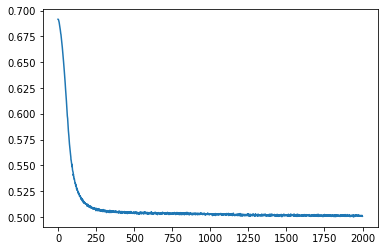

In [ ]:
import matplotlib.pyplot as plt

x = list(range(2000))
plt.plot(x, losses)

In [ ]:
pred_score = []
for i in range(len(df)):
    embedding = bert_model.encode([df['job_title'][i]])
    embedding_tensor = torch.from_numpy(embedding).float()
    pred = round(rank_model.predict(embedding_tensor).detach().numpy().sum(),2)
    pred_score.append(pred)

df['RankNet_score'] = pred_score
df.sort_values(by ='RankNet_score', ascending = False)

,id,job_title,location,connection,fit_TF-IDF,fit_Glove,fit_wave2vec,fit_BERT,score_doc2vec,star_score,RankNet_score
47,99,seeking human resource position,las vegas nevada area,48,0.273133,0.900974,0.654475,0.849293,NaN,0.849293,1.00
13,28,seeking human resource opportunity,chicago illinois,390,0.263981,0.906700,0.691059,0.841447,0.702247,0.841447,1.00
30,82,aspiring human resource professional energetic team focused leader,austin texas area,174,0.330575,0.755774,0.621360,0.885530,NaN,0.885530,1.00
1,2,native english teacher epik english program korea,kanada,500,0.000000,0.521773,0.240536,0.384784,0.680783,1.000000,1.00
24,76,aspiring human resource professional passionate helping create inclusive engaging work environment,new york new york,212,0.255275,0.827730,0.612162,0.754890,NaN,0.754890,1.00
45,97,aspiring human resource professional,kokomo indiana area,71,0.765002,0.847285,0.842219,0.948828,NaN,0.948828,1.00
22,74,human resource professional,greater boston area,16,0.393063,0.927079,0.789636,0.809261,NaN,0.809261,1.00
21,73,aspiring human resource manager seeking internship human resource,houston texas area,7,0.606927,0.903436,0.769422,0.752413,NaN,0.752413,1.00
16,68,human resource specialist luxottica,greater new york city area,500,0.220701,0.872421,0.690994,0.715959,NaN,0.715959,1.00
37,89,director human resource ey,greater atlanta area,349,0.215787,0.902769,0.569956,0.719236,NaN,0.719236,1.00



BERT model was one of the best models to find the similarity between our data and the targeted phrase, and that's why I used its score to feed the model the first time. As for the Ranking model, I run the RankNet model on the data and our best loos score is around 49%.